In [ ]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import getpass
import os
os.environ["HUGGINGFACE_API_KEY"] = getpass.getpass()

··········


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

import pandas as pd
# read data and put it in a dataframe
# 在 google 工作表載入 gsheets
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Ci8bo2FwlIyyuYvKP9icxP1olukYwAvAmPlYHfVObcs/edit?usp=sharing')
# 從 gsheets 的工作表
sheets1 = gsheets.worksheet('stock_news title/stock_news content').get_all_values()

df = pd.DataFrame(sheets1[1:], columns=sheets1[0])


In [ ]:
df.head()

,Title,Content
0,《熱門族群》內資領頭衝 資產股發燙,【時報-台北電】台股29日反彈行情熱絡，類股維持多頭輪動格局，在本土資金領軍衝鋒下，資產概念...
1,中石化啟動轉型 營運添力,中石化（1314）啟動精細／特用化學品、電子級化工材料、能源、氫能低碳產品等四大轉型計畫，力...
2,中石化利基轉型就位發酵 營運添力,中石化（1314）啟動精細／特用化學品、電子級化工材料、能源及氫能低碳產品四大轉型計畫，力拼...
3,《熱門族群》中石化、炎洲 資產開發報喜,【時報-台北電】中石化（1314）、炎洲（4306）、大洋（1321）資產開發部署就位，多元...
4,中石化、炎洲 資產開發報喜,中石化（1314）、炎洲（4306）、大洋（1321）資產開發部署就位，多元收益添利。中石化...


In [ ]:
import re
# 只保留中文字
def keep_chinese_chars(text):
    pattern = re.compile(r'[^\u4e00-\u9fff]')
    chinese_text = re.sub(pattern, '', text)
    return chinese_text

In [ ]:
text = df['Content'][0]
text = keep_chinese_chars(text)
text

'時報台北電台股日反彈行情熱絡類股維持多頭輪動格局在本土資金領軍衝鋒下資產概念股強勢攻高農林中石化雙雙亮燈漲停另士紙新紡等大地主全面走揚在高通膨環境延續下扮演盤面吸金指標群益投顧研究部副總裁曾炎裕指出先前受惠本土資金挹注推升具檔期題材營建股大舉爆衝不過由於近期逐漸出現因籌碼過熱而有強弱分歧的跡象但在整體氛圍仍呈熱絡下部分資金轉移至資產股凱基投顧分析中石化今年首季營收億元季增年增營運呈現復甦態勢主要受惠旗下主要產品己內醯胺及尼龍相關產品營收稼動表現超越預期丙烯月青上半年供給偏緊支撐價格也將增添上半年營運動能激勵股價強攻漲停另外中石化具資產題材也帶動其他資產股聯袂大漲農林漲停作收士紙新紡分別大漲逾躍居盤面焦點新聞來源工商時報一陳昱光台北報導'

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

def Mistral_summarize(text):

  device = "cuda" # the device to load the model onto

  model = AutoModelForCausalLM.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")
  tokenizer = AutoTokenizer.from_pretrained("MediaTek-Research/Breeze-7B-Instruct-v1_0")

  messages = [
      {"role": "user", "content": "What is your favourite condiment?"},
      {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
      {"role": "user", "content": {text}}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
  decoded = tokenizer.batch_decode(generated_ids)

  return decoded

In [ ]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch

def bart_summarize(text):

    keep_chinese_chars(text)

    tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
    model = BertForMaskedLM.from_pretrained('hfl/chinese-bert-wwm')

    inputs = tokenizer(text, return_tensors="pt", max_length=100, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=128)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
summary = bart_summarize(text)
print(summary)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


時 報 台 北 電 台 股 日 反 彈 行 情 熱 絡 類 股 維 持 多 頭 輪 動 格 局 在 本 土 資 金 領 軍 衝 鋒 下 資 產 概 念 股 強 勢 攻 高 農 林 中 石 化 雙 雙 亮 燈 漲 停 另 士 紙 新 紡 等 大 地 主 全 面 走 揚 在 高 通 膨 環 境 延 續 下 扮 演 盤 面 吸 金 指 標 群 益 投 顧 研 究 部 副 總 裁 曾 炎 裕 指 出 現 「 」 的 股 票 ， 如 曾 炎 裕 指 出 ， 有 「 」 的 股 票 是 指 有 「 」 。 」


In [ ]:
def remove_spaces(text):
    # 使用 replace 方法來刪除空格
    return text.replace(" ", "")

output_text = remove_spaces(summary)
output_text

'時報台北電台股日反彈行情熱絡類股維持多頭輪動格局在本土資金領軍衝鋒下資產概念股強勢攻高農林中石化雙雙亮燈漲停另士紙新紡等大地主全面走揚在高通膨環境延續下扮演盤面吸金指標群益投顧研究部副總裁曾炎裕指出現「」的股票，如曾炎裕指出，有「」的股票是指有「」。」'

In [ ]:
import jieba
import jieba.analyse

jieba.analyse.extract_tags(output_text, topK=10)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.889 seconds.
DEBUG:jieba:Loading model cost 0.889 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


['炎裕', '時報', '電台', '股日', '反彈', '熱絡類', '股維持', '多頭', '輪動', '資金領']

In [ ]:
# 使用 jieba 提取關鍵字
def extract_keywords(text):
    #text = keep_chinese_chars(text)

    summary = bart_summarize(text)
    outputt_ext = remove_spaces(summary)

    return jieba.analyse.extract_tags(outputt_ext, topK=10)  # 提取前十個關鍵字

df['keywords'] = df['Content'].apply(extract_keywords)

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a m

In [ ]:
df.head()

,Title,Content,keywords
0,《熱門族群》內資領頭衝 資產股發燙,【時報-台北電】台股29日反彈行情熱絡，類股維持多頭輪動格局，在本土資金領軍衝鋒下，資產概念...,"[台股, 機會, 利息, 時報, 29, 反彈, 熱絡, 類股, 維持, 多頭]"
1,中石化啟動轉型 營運添力,中石化（1314）啟動精細／特用化學品、電子級化工材料、能源、氫能低碳產品等四大轉型計畫，力...,"[hcl, 精細, 預計, 生產, h2o, 中石化, 化工, 1314, 啟動, 特用]"
2,中石化利基轉型就位發酵 營運添力,中石化（1314）啟動精細／特用化學品、電子級化工材料、能源及氫能低碳產品四大轉型計畫，力拼...,"[開始, 精細, 預計, 電能, 等則, 中石化, 化工, 1314, 啟動, 特用]"
3,《熱門族群》中石化、炎洲 資產開發報喜,【時報-台北電】中石化（1314）、炎洲（4306）、大洋（1321）資產開發部署就位，多元...,"[中石化, 越南, 油田, 開發, 萬坪, 時報, 1314, 炎洲, 4306, 1321]"
4,中石化、炎洲 資產開發報喜,中石化（1314）、炎洲（4306）、大洋（1321）資產開發部署就位，多元收益添利。中石化...,"[開發, 萬坪, 中華, 越南, 中石化, 另有, 1314, 炎洲, 4306, 1321]"


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from community import community_louvain

In [ ]:
G = nx.Graph()

for index, row in df.iterrows():
    title = row['Title']
    keywords = row['keywords']

    G.add_node(title, type='Title')

    for keyword in keywords:
        G.add_node(keyword, type='keyword')
        G.add_edge(title, keyword)

In [ ]:
keywords

['股票', '2024', '03', '11', '1314', '單位', '仟元元', '中石化', '日期', '上市公司']

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
from matplotlib.font_manager import fontManager
# 改style要在改font之前
# plt.style.use('seaborn')
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-04-30 03:33:36--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.203.138, 173.194.203.100, 173.194.203.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.203.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-04-30 03:33:36--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.107.132, 2607:f8b0:400e:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  79.4MB/s    in 0.2s    

2024-04-30 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


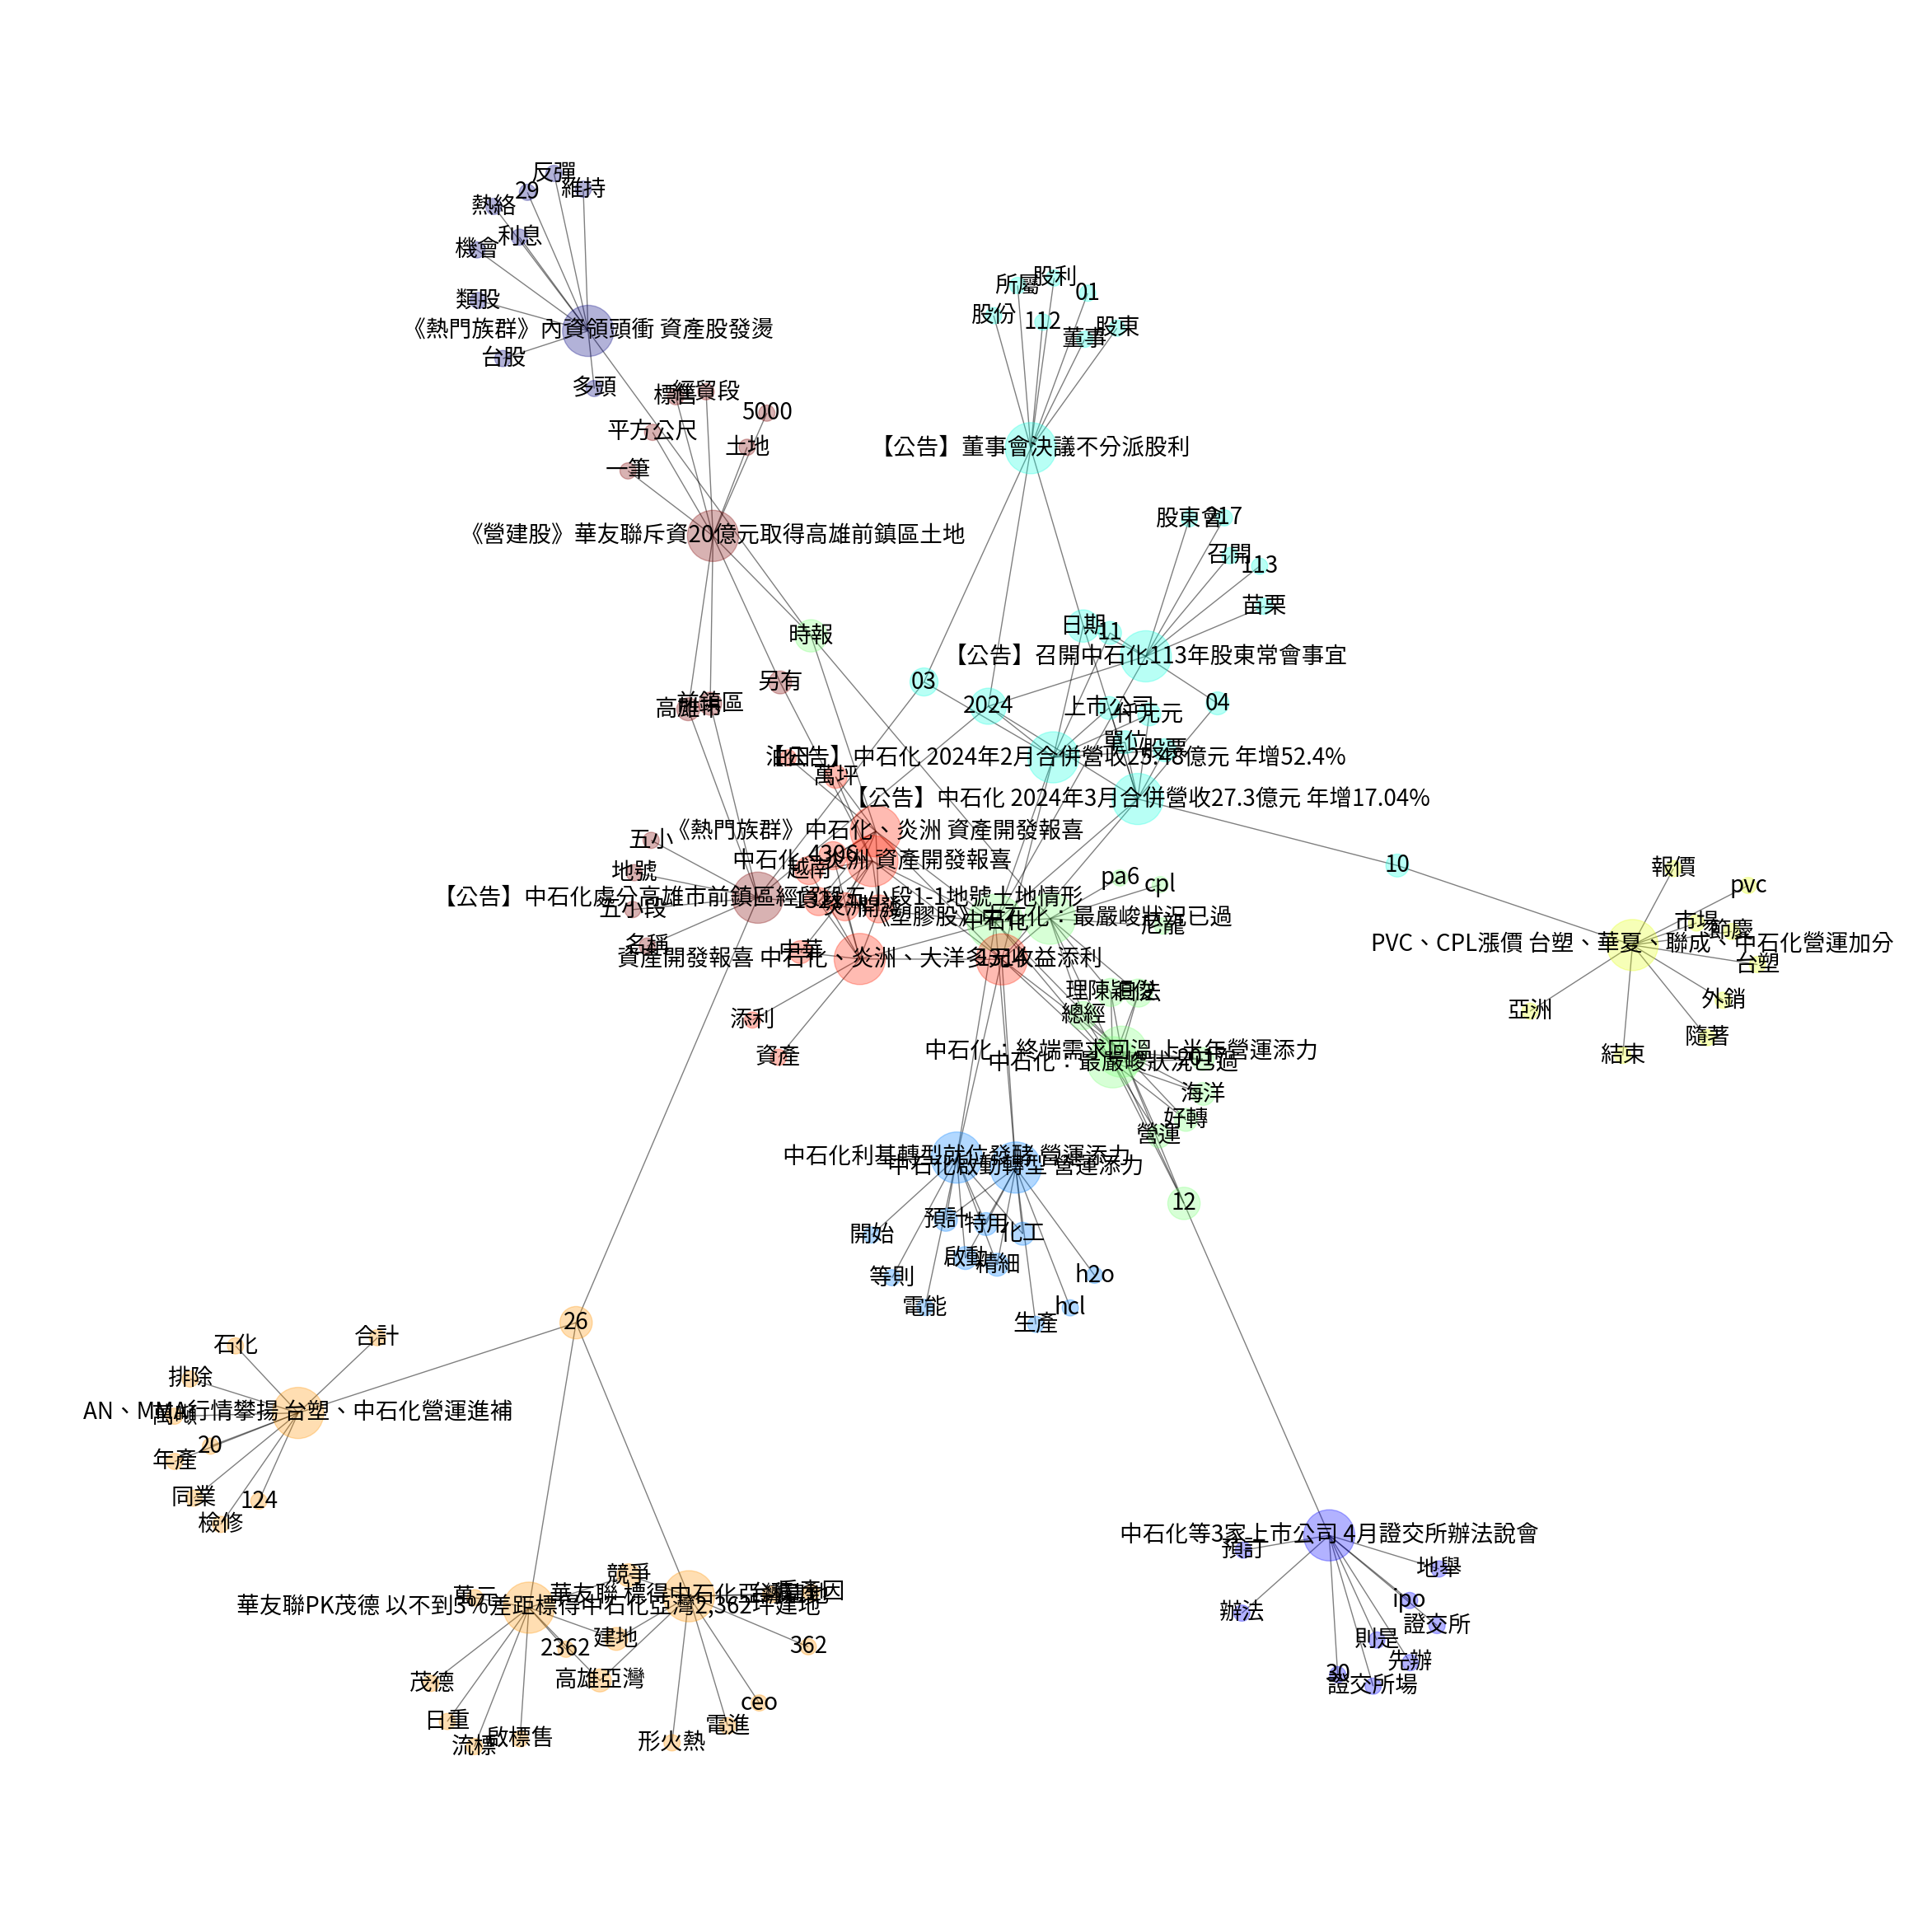

In [ ]:
partition = community_louvain.best_partition(G)

community_colors = [partition[node] for node in G.nodes()]

cmap = plt.cm.jet
colors_with_alpha = [cmap(community_color / max(community_colors)) for community_color in community_colors]

colors_with_alpha = [(r, g, b, 0.3) for r, g, b, _ in colors_with_alpha]

node_sizes = [200 * G.degree(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.2, iterations=80)

plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=colors_with_alpha, node_size=node_sizes, cmap=plt.cm.jet)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Taipei Sans TC Beta')

plt.axis('off')
plt.show()